# Review Session 3 - Tools of Economic Complexity

Linear algebra and complexity variables

**Outline**

- Linear algebra basics
- Networks - construction and metrics
	- Adjacency matrix
	- Edge lists
	- Degree distributions
	- Centrality metrics
	- “Network backboning” - Michele / Frank
- Complexity metrics
	- ECI / PCI / Density
	- Industry spaces - co-production / co-location / co-coordination
    - Predicting product appearances
    - Backing out country CCA's
- Density regressions
	- Growth vs density, country FE
	- Product appearances vs density, country FE
- Growth regressions
    - Growth vs ECI etc.

In [98]:
%reset -f

In [176]:
# Helps while coding up modules to import
%reload_ext autoreload
%autoreload 2

In [99]:
# Basics
import os
import re
import sys
from pathlib import Path

# Data and plotting
import matplotlib.pyplot as plt

# Networks
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

In [173]:
# Set file paths
PROJ = Path(os.path.realpath("."))
ROOT = PROJ.parent
DATA = ROOT / "data/"

In [181]:
# Import additional custom modules
sys.path.append(str(PROJ))
sys.path.append(str(ROOT / "src"))
from network_backboning import *

# Linear Algebra Basics

Great tutorial [here](https://cs231n.github.io/python-numpy-tutorial/)

## Arrays, matrices, and indexing

In [103]:
# Create a matrix and a vector(?)
M = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
v = np.array([[1], [2], [3]])

In [104]:
M

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [105]:
v

array([[1],
       [2],
       [3]])

In [106]:
print(f"Sum: {M.sum()}")
print(f"Sum horizontally (across columns): {M.sum(axis=1)}")
print(f"Sum vertically (across rows): {M.sum(axis=0)}")

Sum: 45
Sum horizontally (across columns): [ 6 15 24]
Sum vertically (across rows): [12 15 18]


In [107]:
M.shape

(3, 3)

In [108]:
v.shape

(3, 1)

In [109]:
v.ndim

2

In [110]:
np.array([1, 2, 3]).shape

(3,)

In [111]:
np.ones((2, 4))

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.]])

In [112]:
np.diag([1, 2, 3, 4])

array([[1, 0, 0, 0],
       [0, 2, 0, 0],
       [0, 0, 3, 0],
       [0, 0, 0, 4]])

In [113]:
np.eye(3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

Indexing: selecting elements of list / arrays / matrices based on their positions

In [114]:
test_list = ["a", "b", "c", "d", "e"]
test_list[3:5]

['d', 'e']

In [115]:
test_arr = np.array(range(100, 120))
test_arr

array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 118, 119])

In [116]:
test_arr[5:8]

array([105, 106, 107])

In [117]:
test_mat = np.random.randint(30, 60, (5, 5))
test_mat

array([[56, 43, 30, 43, 58],
       [31, 58, 52, 40, 45],
       [41, 45, 53, 34, 43],
       [54, 49, 51, 38, 36],
       [55, 42, 53, 52, 38]])

In [118]:
test_mat[:3, 1:3]

array([[43, 30],
       [58, 52],
       [45, 53]])

## Broadcasting

In [119]:
x = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]])
v = np.array([1, 0, 1])

In [120]:
x

array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12]])

In [121]:
v

array([1, 0, 1])

In [122]:
x + v

array([[ 2,  2,  4],
       [ 5,  5,  7],
       [ 8,  8, 10],
       [11, 11, 13]])

## Matrix multiplication

$A \cdot B$

$A \times B$

In [123]:
# Create two random matrices
A = np.random.randint(0, 5, (4, 3))
B = np.random.randint(0, 6, (2, 3))

In [124]:
# Dot product
try:
    print("Trying dot product")
    print(A @ B)
except Exception as e:
    print(e)
    print("Oops")
    print(A @ B.T)

Trying dot product
matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 3)
Oops
[[15 12]
 [10 16]
 [15 11]
 [ 0  4]]


In [125]:
# Dot product
np.array_equal(A @ B.T, A.dot(B.T))

True

In [126]:
# Cross product
np.cross([1, 2, 3], [8, 5, 6])

array([ -3,  18, -11])

In [127]:
# Element-wise
A * np.eye(A.shape[0], A.shape[1])

array([[0., 0., 0.],
       [0., 2., 0.],
       [0., 0., 2.],
       [0., 0., 0.]])

## Eigenvectors

In [128]:
# Eigenvalues / vectors
eigval, eigvec = np.linalg.eig(np.random.randint(0, 5, (3, 3)))

In [129]:
eigval

array([ 9.29420244, -0.15057759, -2.14362484])

In [130]:
eigvec

array([[-0.55260029, -0.78031529,  0.42828166],
       [-0.47354263,  0.24340776, -0.89011208],
       [-0.68585006,  0.57607353,  0.15580534]])

# Networks

[Alternatives to networkx](https://www.timlrx.com/blog/benchmark-of-popular-graph-network-packages) - igraph (somewhat fast, very stable), graph-tool (very fast, not as stable), networkit

## Basics

In [131]:
# Proximities from the atlas
proxurl = (
    "http://intl-atlas-downloads.s3.amazonaws.com/atlas_2_16_6/hs92_proximities.csv"
)
proxdf = pd.read_csv(
    proxurl, dtype={"commoditycode_1": str, "commoditycode_2": str, "proximity": float}
)
proxdf.head()

,commoditycode_1,commoditycode_2,proximity
0,0101,0101,0.000000
1,0101,0102,0.277778
2,0101,0103,0.352941
3,0101,0104,0.260870
4,0101,0105,0.296296


In [133]:
# Prepare node attributes

# Read HS product codes
hsurl = "http://intl-atlas-downloads.s3.amazonaws.com/17.0/hs_product.zip"
hsdf = pd.read_csv(hsurl, compression="zip", dtype="str")
# Only keep products present in proximity matrix
nodedf = (
    hsdf[hsdf.hs_product_code.isin(proxdf.commoditycode_1)][
        ["hs_product_code", "hs_product_name_short_en"]
    ]
    .sort_values("hs_product_code")
    .reset_index(drop=True)
)
nodedf.head()

,hs_product_code,hs_product_name_short_en
0,0101,Horses
1,0102,Bovine
2,0103,Swine
3,0104,Sheep
4,0105,Fowl


In [134]:
# Create network
product_nw = nx.from_pandas_edgelist(
    proxdf, source="commoditycode_1", target="commoditycode_2", edge_attr=True
)
# Set node attributes
nx.set_node_attributes(product_nw, nodedf.set_index("hs_product_code").to_dict("index"))

In [135]:
product_nw.nodes["0101"]

{'hs_product_name_short_en': 'Horses'}

## Visualization

In [236]:
def draw_network(
    nw,
    node_pos=None,
    node_color=None,
    node_size=None,
    edge_color=(0, 0, 0, 0.1),
    ax=None,
    figsize=(15, 15),
    **kwargs
):
    """
    Draw network using networkx

    Args:
        nw: networkx graph
        node_pos: node positions dictionary keyed by node
        node_color: "attr" indicates "color" node attribute holds colors
        node_size: "attr" indicates "size" node attribute holds sizes
        edge_color: edge colors, default is black

    """
    if node_color == "attr":
        node_color = nx.get_node_attributes(nw, "color")
    if node_size == "attr":
        node_size = nx.get_node_attributes(nw, "size")
    if ax is None:
        f, ax = plt.subplots(figsize=figsize)
    # Draw network
    ax = nx.draw_networkx(
        nw,
        pos=node_pos,
        with_labels=False,
        node_size=node_size,
        node_color=node_color,
        edge_color=edge_color,
        ax=ax,
        **kwargs
    )
    return ax

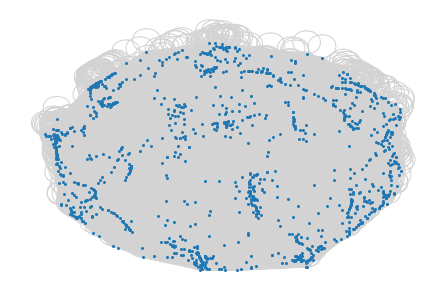

In [137]:
# Visualize giant component
components = sorted(nx.connected_components(product_nw), key=len, reverse=True)
giant_component = product_nw.subgraph(components[0])
# Draw network
nx.draw(giant_component, node_size=4, edge_color="lightgrey")

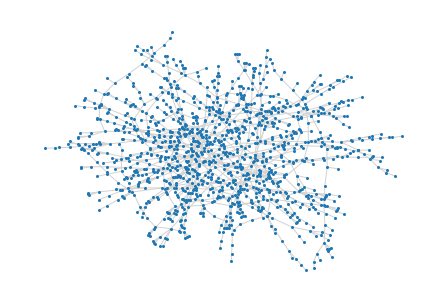

In [144]:
# Visualize mst
mst = nx.maximum_spanning_tree(product_nw, weight="proximity")
# Draw network
nx.draw(mst, node_size=4, edge_color="lightgrey")

In [183]:
# List available attributes
available_node_attributes = lambda g: set(
    [k for n in g.nodes for k in g.nodes[n].keys()]
)
available_edge_attributes = lambda g: set(
    [k for n in g.edges for k in g.edges[n].keys()]
)

In [186]:
available_node_attributes(product_nw)

{'hs_product_name_short_en'}

In [187]:
available_edge_attributes(product_nw)

{'proximity'}

## Backboning

In [210]:
# Network backboning
g = giant_component
g_denoised = noise_correct_nw(g, weightcol="proximity", noise_correction_threshold=0.8)

In [212]:
print(f"Number of edges goes from {g.number_of_edges()} to {g_denoised.number_of_edges()}")

Number of edges goes from 769420 to 9923


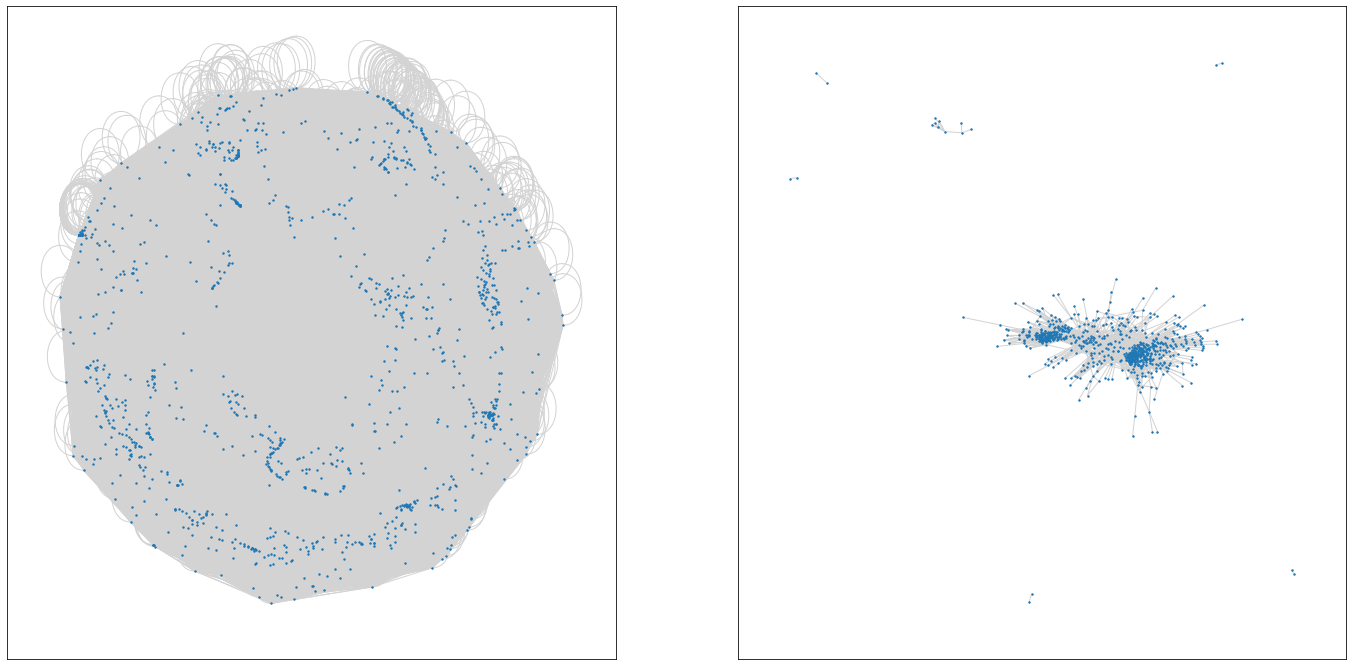

In [235]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))
draw_network(g, node_size=2, edge_color="lightgrey", ax=ax1)
draw_network(g_denoised, node_size=2, edge_color="lightgrey", ax=ax2)

## Centrality Measures

In [ ]:
centrality_degree = nx.degree_centrality(product_nw)
